# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [3]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 216 kB 44.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 82.2 MB/s eta 0:00:01


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,)),
                                transforms.Lambda(lambda x: torch.flatten(x))])

# Create training set and define training dataloader
training_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=32, shuffle=True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

Here we did three operations:

1. **Transforming the PIL image to a torch tensor**  
   - Otherwise, the network cannot process the input.

2. **Normalizing the pixel values to be between [-1, 1]**  
   - This helps gradient descent converge faster and more reliably.  
   - We pass only **one value for the mean and one value for the standard deviation**  
     because MNIST images are grayscale (they have **one channel**).  
     For RGB images (3 channels), we would pass three values (one per channel).

3. **Flattening the data**  
   - We could have done this later (just before passing the input to the network),  
     but we include it here inside `transforms.Compose` for cleaner and more organized preprocessing.  
   - The flattening transforms each image from shape **[1, 28, 28]** into a **1D vector of length 28 * 28 * 1 = 784**.  
     This is the format expected by a fully connected feedforward neural network.


**DOUBLE CLICK THIS CELL TO MODIFY**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [38]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Single image shape: torch.Size([1, 28, 28])
Label: 5
Batch image shape: torch.Size([5, 1, 28, 28])
Batch labels shape: torch.Size([5])
--------------------
5


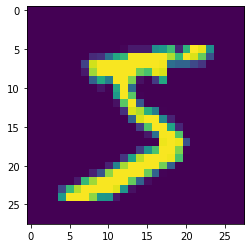

0


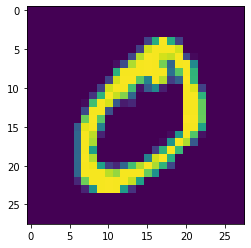

4


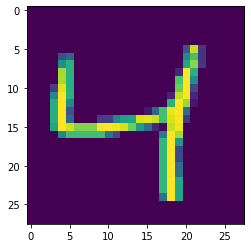

1


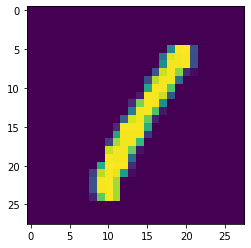

9


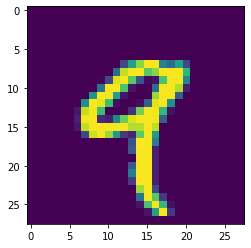

In [44]:
# Explore data
explore_transform = transforms.Compose([
    transforms.ToTensor()
])
explore_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=explore_transform)
explore_loader = torch.utils.data.DataLoader(explore_data, batch_size=5)

# one sample from dataset
img, label = explore_data[0]
print("Single image shape:", img.shape) 
print("Label:", label)

# one batch from explore_loader
images, labels = next(iter(explore_loader))
print("Batch image shape:", images.shape)  
print("Batch labels shape:", labels.shape)
print("--------------------")
show5(explore_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [15]:
class MLP_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 125)
        self.fc2 = nn.Linear(125, 70)
        self.fc3 = nn.Linear(70, 10)
        
    def forward(self, x):
        x = self.activation(self.fc1(x)) # already flatten
        x = self.activation(self.fc2(x))
        x = self.fc3(x)                  # logits 
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [19]:
net = MLP_net()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

optimizer = optim.Adam(params=net.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss() # we have multi-class classification problem



## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [20]:
num_epochs = 10
train_acc_list = list()
train_loss_list = list()

def train(network):
    for epoch in range(num_epochs):
        train_correct = 0
        train_loss = 0.0
        total_samples = 0
        # enable training mode
        network.train()
        for i, data in enumerate(training_loader):
            # data is in the form of [img, label]
            images, labels = data

            # moving the data to device = "cuda"
            images, labels = images.to(device), labels.to(device)

            # zeroing the optimizer
            optimizer.zero_grad()

            # getting the output of the network
            outputs = network(images)

            # calculating the loss
            loss = criterion(outputs, labels)

            # compute gradiens
            loss.backward()

            #one step of optimizer
            optimizer.step()

            # now, we can see the predicted classes
            # taking the class with the max logit among the 10 outputed values
            _, preds = torch.max(outputs.data, 1)

            # recording the number of correct preds and the loss
            train_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
            train_loss += loss.item()

            # print batch progress every 250 steps
            if i % 250 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] | Step [{i}/{len(training_loader)}] "
                  f"| Batch Loss: {loss.item():.4f}")

        # epoch metrics
        epoch_loss = train_loss / len(training_loader)
        epoch_acc = 100 * train_correct / total_samples

        train_loss_list.append(epoch_loss)
        train_acc_list.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] finished | "
        f"Avg Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")
        

train(net)

Epoch [1/10] | Step [0/1875] | Batch Loss: 2.3620
Epoch [1/10] | Step [250/1875] | Batch Loss: 0.4769
Epoch [1/10] | Step [500/1875] | Batch Loss: 0.3321
Epoch [1/10] | Step [750/1875] | Batch Loss: 0.2174
Epoch [1/10] | Step [1000/1875] | Batch Loss: 0.4140
Epoch [1/10] | Step [1250/1875] | Batch Loss: 0.3507
Epoch [1/10] | Step [1500/1875] | Batch Loss: 0.2087
Epoch [1/10] | Step [1750/1875] | Batch Loss: 0.3011
Epoch [1/10] finished | Avg Loss: 0.3538 | Accuracy: 89.19%
Epoch [2/10] | Step [0/1875] | Batch Loss: 0.2118
Epoch [2/10] | Step [250/1875] | Batch Loss: 0.0549
Epoch [2/10] | Step [500/1875] | Batch Loss: 0.0857
Epoch [2/10] | Step [750/1875] | Batch Loss: 0.1470
Epoch [2/10] | Step [1000/1875] | Batch Loss: 0.0100
Epoch [2/10] | Step [1250/1875] | Batch Loss: 0.3841
Epoch [2/10] | Step [1500/1875] | Batch Loss: 0.0937
Epoch [2/10] | Step [1750/1875] | Batch Loss: 0.2455
Epoch [2/10] finished | Avg Loss: 0.1698 | Accuracy: 94.76%
Epoch [3/10] | Step [0/1875] | Batch Loss: 0

Plot the training loss (and validation loss/accuracy, if recorded).

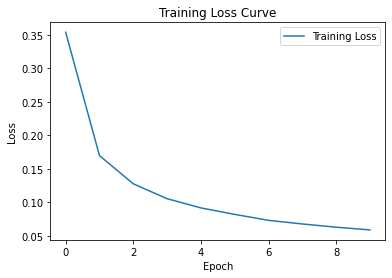

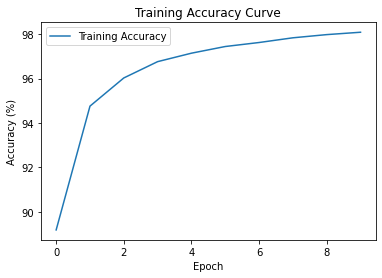

In [21]:
plt.plot(train_loss_list, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

plt.plot(train_acc_list, label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [22]:
# Test process
def test(network):
    network.eval()

    test_loss = 0.0
    test_correct = 0
    total_samples = 0

    with torch.no_grad():   # no need to track gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = network(images)

            loss = criterion(outputs, labels)

            # predictions
            _, preds = torch.max(outputs, 1)

            # accumulate stats
            test_correct += (preds == labels).sum().item()
            test_loss += loss.item()
            total_samples += labels.size(0)

    # average loss per batch
    avg_test_loss = test_loss / len(test_loader)
    # accuracy
    test_acc = 100 * test_correct / total_samples

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    
test(net)


Test Loss: 0.1007, Test Accuracy: 96.98%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [24]:
# here we are going to implement the dropout mechanism 
class MLP_net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(784, 125)
        self.fc2 = nn.Linear(125, 70)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(70, 10)

    def forward(self, x):
        x = self.activation(self.fc1(x)) # already flatten
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)                 
        return x
    
net2 = MLP_net() 
net2.to(device)
optimizer = optim.Adam(net2.parameters(), lr=0.001)



In [25]:
train(net2)

Epoch [1/10] | Step [0/1875] | Batch Loss: 2.3133
Epoch [1/10] | Step [250/1875] | Batch Loss: 0.7221
Epoch [1/10] | Step [500/1875] | Batch Loss: 0.1401
Epoch [1/10] | Step [750/1875] | Batch Loss: 0.1720
Epoch [1/10] | Step [1000/1875] | Batch Loss: 0.3754
Epoch [1/10] | Step [1250/1875] | Batch Loss: 0.2760
Epoch [1/10] | Step [1500/1875] | Batch Loss: 0.0632
Epoch [1/10] | Step [1750/1875] | Batch Loss: 0.1924
Epoch [1/10] finished | Avg Loss: 0.3572 | Accuracy: 89.20%
Epoch [2/10] | Step [0/1875] | Batch Loss: 0.1525
Epoch [2/10] | Step [250/1875] | Batch Loss: 0.2019
Epoch [2/10] | Step [500/1875] | Batch Loss: 0.2889
Epoch [2/10] | Step [750/1875] | Batch Loss: 0.1353
Epoch [2/10] | Step [1000/1875] | Batch Loss: 0.2241
Epoch [2/10] | Step [1250/1875] | Batch Loss: 0.2108
Epoch [2/10] | Step [1500/1875] | Batch Loss: 0.1113
Epoch [2/10] | Step [1750/1875] | Batch Loss: 0.4751
Epoch [2/10] finished | Avg Loss: 0.1729 | Accuracy: 94.81%
Epoch [3/10] | Step [0/1875] | Batch Loss: 0

In [26]:
test(net2)

Test Loss: 0.0981, Test Accuracy: 97.23%


## Saving your model
Using `torch.save`, save your model for future loading.

In [27]:
# w're saving the second network that gave a slightly better test acc performance ()
torch.save(net2.state_dict(), "best_mnist_model.pth")